# Constrain Cosmological Parameters using Supernovae Data

This notebook uses supernavae data, specifically, the data of the distance modulus vs. redshift to fit equations and constrain cosmological constants.

Here is an overview of our methods:
1) Fetch supernova data

2) Visualize data and get the data where redshift is small

3) Fit data with small redshift to the following equation and use the fitting results to calculate Hubble Constant $H_0$ and cosmological constant $q_0$.

$m - M = 43.17 - 5log_{10}(\frac{H_0}{70}) + 5log_{10}z + 1.086(1-q_0)z$           ------ (Eq. 1)


To better understand our data, we also try fitting our data backwards in the following steps, i.e., how well different $q_0$ fits our data.

4) Visualize the difference between our data fitted model and some hypothesized models.

5) Try different cosmological constants on our data and calculate the loss for each.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

## 1. Load Supernovae Data

In [2]:
sn_data = pd.read_csv("./data.txt", sep="\t", header=0)
sn_data.head()

,supernova name,redshift,distance modulus,distance modulus error,probability
0,1993ah,0.028488,35.346583,0.223906,0.128419
1,1993ag,0.050043,36.682368,0.166829,0.128419
2,1993o,0.052926,36.817691,0.155756,0.128419
3,1993b,0.070086,37.446737,0.158467,0.128419
4,1992bs,0.062668,37.483409,0.156099,0.128419


## 2. Visualize Data

We observe a log relationship between distance modulus and redshift.

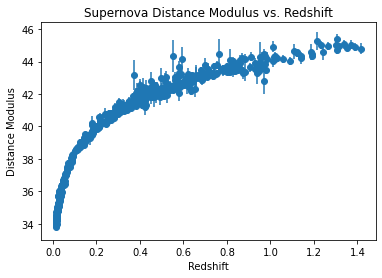

In [3]:
plt.errorbar(sn_data["redshift"], sn_data["distance modulus"], yerr = sn_data["distance modulus error"], xerr=None, fmt='o')
plt.xlabel('Redshift')
plt.ylabel('Distance Modulus')
plt.title('Supernova Distance Modulus vs. Redshift')
plt.show()

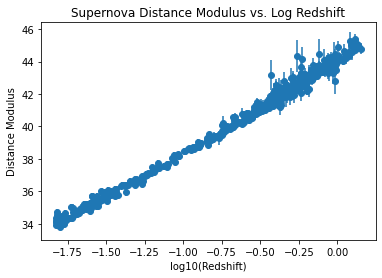

In [4]:
plt.errorbar(np.log10(sn_data["redshift"]), sn_data["distance modulus"], yerr = sn_data["distance modulus error"], xerr=None, fmt='o')
plt.xlabel('log10(Redshift)')
plt.ylabel('Distance Modulus')
plt.title('Supernova Distance Modulus vs. Log Redshift')
plt.show()

Now we can extract two dataset: `small_z_data` and `medium_z_data`.

`small_z_data` contains the supernova data that has a very small redshift(z<<1), and `medium_z_data` contains the data with relatively bigger redshift but still smaller than 0.2(z<0.2).

We will introduce the use of these two datasets later.

In [5]:
small_z_data = sn_data[sn_data["redshift"] < 0.055]
medium_z_data = sn_data[sn_data["redshift"] < 0.2]
print("Number of points in small_z_data: ", len(small_z_data), "\nNumber of points in medium_z_data: ", len(medium_z_data))

Number of points in small_z_data:  146 
Number of points in medium_z_data:  230


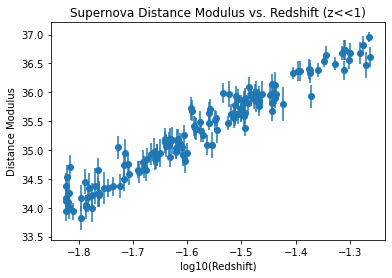

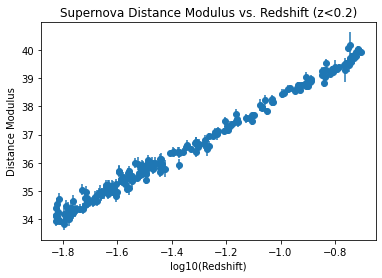

In [6]:
plt.errorbar(np.log10(small_z_data["redshift"]), small_z_data["distance modulus"], yerr = small_z_data["distance modulus error"], xerr=None, fmt='o')
plt.xlabel('log10(Redshift)')
plt.ylabel('Distance Modulus')
plt.title('Supernova Distance Modulus vs. Redshift (z<<1)')
plt.show()

plt.errorbar(np.log10(medium_z_data["redshift"]), medium_z_data["distance modulus"], yerr = medium_z_data["distance modulus error"], xerr=None, fmt='o')
plt.xlabel('log10(Redshift)')
plt.ylabel('Distance Modulus')
plt.title('Supernova Distance Modulus vs. Redshift (z<0.2)')
plt.show()

## 3. Fit Data and Calculate Hubble Constant and Cosmological Constant

Equation 1: $m - M = 43.17 - 5log_{10}(\frac{H_0}{70}) + 5log_{10}z + 1.086(1-q_0)z$

Observe that when z<<1, we can neglect the last term $1.086(1-q_0)z$. The distance modulus and $log_{10}z$ are linear. So we can use the data when z<<1 to fit a linear regression model. The fitted intercept can be used to calculate Hubble constant $H_0$.

To take into account the error bars, we use weighted least squares where the weights are calculated from distance modulus error.

In [7]:
X = np.array(np.log10(small_z_data["redshift"])).reshape(-1, 1)
X = sm.add_constant(X) # add column of 1 for intercept
y = np.array(small_z_data["distance modulus"])

# Weights for weighted least squares
weights = 1 / np.array(small_z_data["distance modulus error"]) ** 2

H0_model = sm.WLS(y, X, weights=weights).fit()
H0_model.params

array([43.26060668,  5.03219119])

In [8]:
H0_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.951
Model:                            WLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     2806.
Date:                Fri, 05 May 2023   Prob (F-statistic):           2.55e-96
Time:                        16:14:01   Log-Likelihood:                 43.463
No. Observations:                 146   AIC:                            -82.93
Df Residuals:                     144   BIC:                            -76.96
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.2606      0.147    293.727      0.000      42.969      43.552
x1             5.0322      0.095     52.973      0.000       4.844       5.220
==============================================================================
Omnibus:                        1.446   Durbin-Watson:                   1.654
Prob(Omnibus):                  0.485   Jarque-Bera (JB):                1.013
Skew:                           0.126   Prob(JB):                        0.603
Kurtosis:                       3.320   Cond. No.                         22.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
H0 = 70 * 10**((H0_model.params[0] - 43.17) / (-5.0))
print("H0:", H0)

H0: 67.13928363809563


Our linear model fits the data well with $R^2$ close to 1. We calculate $H_0$ around 67.14, which is also consistent with other studies.

Now, we could use slightly bigger z to fit the last term $1.086(1-q_0)z$ to calculate $q_0$.

In [10]:
X = np.array((medium_z_data["redshift"])).reshape(-1, 1)
X = sm.add_constant(X)
y = np.array(medium_z_data["distance modulus"]) - 5*np.array(np.log10(medium_z_data["redshift"])) - H0_model.params[0]

# Weights for weighted least squares
weights = 1 / np.array(medium_z_data["distance modulus error"]) ** 2

q0_model = sm.WLS(y, X, weights=weights).fit()
q0_model.params

array([-0.09279572,  1.43659398])

In [11]:
q0 = 1 - q0_model.params[1]/1.086
print("q0:", q0)

q0: -0.3228305557712643


We get $q_0 < 0$, indicating that we are in an accelarating outward universe.

We could also directly fit data with small redshift to the whole equation, by indicating the model as $m-M = b + a_0log_{10}z + a_1z$.

In [12]:
X0 = np.array(np.log10(medium_z_data["redshift"])).reshape(-1, 1)
X1 = np.array((medium_z_data["redshift"])).reshape(-1, 1)
X = np.append(X0, X1, axis = 1)

X = sm.add_constant(X)
y = np.array(medium_z_data["distance modulus"])

# Weights for weighted least squares
weights = 1 / np.array(medium_z_data["distance modulus error"]) ** 2

model = sm.WLS(y, X, weights=weights).fit()
model.params

array([43.1024494 ,  4.96133736,  1.66229566])

In [13]:
H0 = 70 * 10**((model.params[0] - 43.17) / (-5.0))
print("H0:", H0)
q0 = 1 - model.params[2]/1.086
print("q0:", q0)

H0: 72.21179809082025
q0: -0.530658990003376


Similarly, we find an accelarating universe.

## 4. Compare Observational Results and Expected Results for three Model Universes

One universe is flat, and contains only matter ($\Omega_{m,0}=1, q_0=0.5$). The second universe is negatively curved, and contains only matter ($\Omega_{m,0}=0.3, q_0=0.15$). The third universe is flat, and contains both matter and a cosmological constant ($\Omega_{m,0}=0.3, \Omega_{\Lambda,0}=0.7, q_0=-0.55$). The data are best fitted by the thrid model.

In [57]:
def calculate_dm(q0, z_data):
    dm = model.params[0] + 5*np.array(np.log10(z_data)) + 1.086*(1-q0)*np.array(z_data)
    return dm

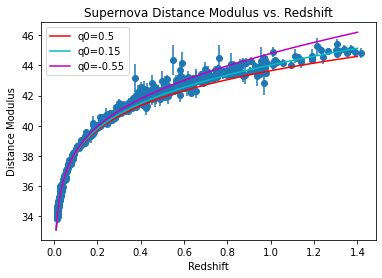

In [75]:
plt.errorbar(sn_data["redshift"], sn_data["distance modulus"], yerr = sn_data["distance modulus error"], xerr=None, fmt='o', zorder=0)

z_data = np.linspace(10**(-2), 1.4, num=300)

plt.plot(z_data, calculate_dm(0.5, z_data), 'r', label="q0=0.5")
plt.plot(z_data, calculate_dm(0.15, z_data), 'c', label="q0=0.15")
plt.plot(z_data, calculate_dm(-0.55, z_data), 'm', label="q0=-0.55")


plt.xlabel('Redshift')
plt.ylabel('Distance Modulus')
plt.title('Supernova Distance Modulus vs. Redshift')
plt.legend()
plt.show()

Comparing the expected results of three model universes and our observed results, we found that if using the whole dataset when z ranges from 0 to 1.4, the model of q0=0.15 seems to fit best. Yet, equation 1 is most accurate when redshift z is small, so let's fit these models to smaller redshift data.

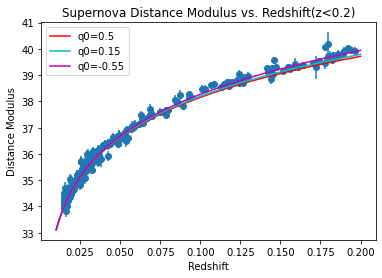

In [81]:
plt.errorbar(medium_z_data["redshift"], medium_z_data["distance modulus"], yerr = medium_z_data["distance modulus error"], xerr=None, fmt='o', zorder=0)

z_data = np.linspace(10**(-2), 0.2, num=300)

plt.plot(z_data, calculate_dm(0.5, z_data), 'r', label="q0=0.5")
plt.plot(z_data, calculate_dm(0.15, z_data), 'c', label="q0=0.15")
plt.plot(z_data, calculate_dm(-0.55, z_data), 'm', label="q0=-0.55")


plt.xlabel('Redshift')
plt.ylabel('Distance Modulus')
plt.title('Supernova Distance Modulus vs. Redshift(z<0.2)')
plt.legend()
plt.show()

We see that three lines are close when z is small, since the last term $1.086(1-q_0)z$ of Equation 1 is neglegible when z<<1. At larger z, three lines deviates. We can zoom in the parts where three line deviates to observe better.

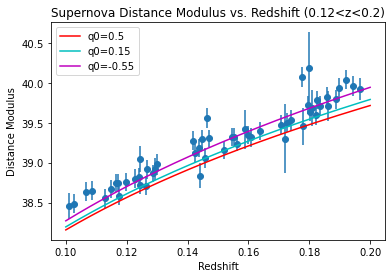

In [85]:
medium_large_z_data = medium_z_data[medium_z_data["redshift"] > 0.1]
plt.errorbar(medium_large_z_data["redshift"], medium_large_z_data["distance modulus"], yerr = medium_large_z_data["distance modulus error"], xerr=None, fmt='o', zorder=0)

z_data = np.linspace(0.1, 0.2, num=200)

plt.plot(z_data, calculate_dm(0.5, z_data), 'r', label="q0=0.5")
plt.plot(z_data, calculate_dm(0.15, z_data), 'c', label="q0=0.15")
plt.plot(z_data, calculate_dm(-0.55, z_data), 'm', label="q0=-0.55")


plt.xlabel('Redshift')
plt.ylabel('Distance Modulus')
plt.title('Supernova Distance Modulus vs. Redshift (0.12<z<0.2)')
plt.legend()
plt.show()



After zooming in, we observe that the third model, where $q_0=-0.55$ best describes our data, which is consistent with our findings in Part 3.

## 5. Fitting with Different Cosmological Constants

In [27]:
def mean_squared_error(predict, true):
    return np.mean((predict - true) ** 2)

In [ ]:
losses = []
q0s = np.linspace(-3, 3, 50)

for q0 in q0s:
    prediction = [calculate_dm(10, z) for z in sn_data["redshift"]]  
    losses.append(mean_squared_error(prediction, sn_data["distance modulus"]))

plt.plot(q0s, losses)

plt.xlabel('q0')
plt.ylabel('Loss (Mean Squared Error)')
plt.title('q0 vs Loss on Observed Data')
plt.show()